In [1]:
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx

c:\Users\Administrator\.conda\envs\ox\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## filter

In [2]:
# cf = '["highway"~"primary|secondary|tertiary|trunk|motorway"]'
# G = ox.graph_from_bbox(31.9, 32.1, 118.9, 118.6, network_type='drive',custom_filter=cf)
# ox.plot_graph(G)

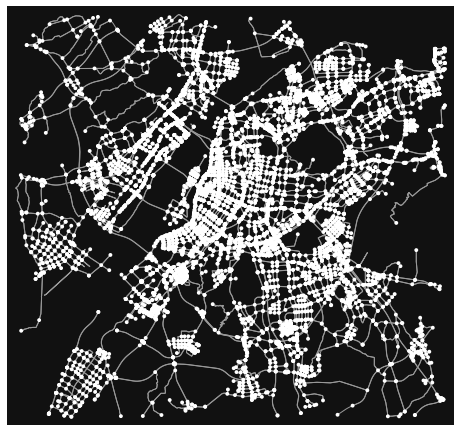

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
cf = '["highway"~"primary|secondary|tertiary|trunk|motorway"]'
G = ox.graph_from_bbox(31.8, 32.2, 119, 118.5, network_type='drive',custom_filter=cf)
ox.plot_graph(G)

In [4]:
raster_path = "E:/Data/DSM/nj_dsm.tif"
G = ox.elevation.add_node_elevations_raster(G, raster_path)
# add edge grades and their absolute values
G = ox.elevation.add_edge_grades(G, add_absolute=True)

In [5]:
dsm_gdf_nodes, dsm_gdf_edges = ox.graph_to_gdfs(G)

In [6]:
ox.save_graph_shapefile(G,"NJ_NoCorrection")

c:\Users\Administrator\.conda\envs\ox\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


### DEM

### FAB

In [7]:
raster_path = ["E:\Data\FABDEM\\NJ\\N32E118_FABDEM.tif","E:\Data\FABDEM\\NJ\\N31E118_FABDEM.tif"]
G_1 = ox.graph_from_bbox(31.8, 32.2, 119, 118.5, network_type='drive',custom_filter=cf)
G_DEM = ox.elevation.add_node_elevations_raster(G_1, raster_path)
# add edge grades and their absolute values
G_DEM = ox.elevation.add_edge_grades(G_DEM, add_absolute=True)

In [8]:
dem_gdf_nodes, dem_gdf_edges = ox.graph_to_gdfs(G_DEM)

In [9]:
_dem_gdf_edges = dem_gdf_edges.copy()
del _dem_gdf_edges['geometry']
_dem_gdf_edges = _dem_gdf_edges.add_suffix('_dem')
_dem_gdf_edges.describe()

,length_dem,grade_dem,grade_abs_dem
count,16950.000000,16946.000000,16946.000000
mean,408.497337,-0.000086,0.006920
std,622.832030,0.022094,0.020982
min,0.579000,-1.047000,0.000000
25%,33.171500,-0.003000,0.001000
50%,258.019000,0.000000,0.002000
75%,530.559500,0.002000,0.007000
max,11107.316000,1.047000,1.047000


In [10]:
concat_gdf_edges = pd.concat([dsm_gdf_edges,_dem_gdf_edges],axis=1)

## 找到DSM坡降大于DEM坡降的边

In [11]:
higher_grade_edges = concat_gdf_edges[concat_gdf_edges["grade_abs"]>concat_gdf_edges["grade_abs_dem"]]

In [12]:
modify_nodes = {}
modify_nodes

{}

In [13]:
modify_nodes_set = {}
modify_nodes_set

{}

In [14]:
def push_modify_nodes(node_id,node_elevation):
    if modify_nodes.__contains__(node_id):   
        modify_nodes[node_id].append(node_elevation)
    else:
        modify_nodes[node_id] = [node_elevation]

In [15]:
def modify_node(u_node_id,v_node_id,length,taget_grades):
    u_diff = G.nodes[u_node_id]["elevation"] - G_DEM.nodes[u_node_id]["elevation"]
    v_diff = G.nodes[v_node_id]["elevation"] - G_DEM.nodes[v_node_id]["elevation"]
    if u_diff > 0 and v_diff > 0:
        if u_diff < v_diff:
            push_modify_nodes(v_node_id,G.nodes[u_node_id]["elevation"] + length * taget_grades)
        else:
            push_modify_nodes(u_node_id,G.nodes[v_node_id]["elevation"] + length * taget_grades)
    elif u_diff < 0 and v_diff < 0:
        push_modify_nodes(v_node_id,G_DEM.nodes[v_node_id]["elevation"])
        push_modify_nodes(u_node_id,G_DEM.nodes[u_node_id]["elevation"])
    else:
        if u_diff > 0:
            push_modify_nodes(v_node_id,G.nodes[u_node_id]["elevation"] + length * taget_grades)
        else:
            push_modify_nodes(u_node_id,G.nodes[v_node_id]["elevation"] + length * taget_grades)

In [16]:
for index,row in higher_grade_edges.iterrows():
    if "link" not in row["highway"]:
        modify_node(index[0],index[1],row["length"],row["grade_abs_dem"])

In [17]:
modify_nodes_stat = {}

In [18]:
for key, value in modify_nodes.items():
    modify_nodes_stat[key] = {"mean":np.mean(value),"std":np.std(value),"max":np.max(value),"min":np.min(value),"median":np.median(value)}

## 更新osm数据

In [19]:
import itertools

In [20]:
def get_min_mean_group_var(arr):
    combinations = []
    for i in range(2,len(arr)+1):
        iter = itertools.combinations(arr,i)
        combinations.append(list(iter))
    std = np.std(arr)
    min_group = arr
    for item in combinations:
        if np.std(item)<=std:
            std = np.std(item)
            min_group = item
    return {"mean":np.mean(min_group),"std":np.std(min_group),"max":np.max(min_group),"min":np.min(min_group),"mean_group":min_group}
        

In [21]:
for key, value in modify_nodes.items():
    get_min_mean_group_var(value)["mean"]

### 节点高程处理

In [22]:
# for key, value in modify_nodes_stat.items():
#     attrs = {key: {"elevation": value["mean"]}}
#     nx.set_node_attributes(G, attrs)

In [23]:
# 避免重复隧道处理
for node in G.nodes:
    G.nodes[node]["istunnel"] = False 
    G.nodes[node]["isbridge"] = False

In [24]:
for key, value in modify_nodes.items():
    attrs = {key: {"elevation": get_min_mean_group_var(value)["mean"]} }
    nx.set_node_attributes(G, attrs)

### 隧道处理

In [25]:
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    if G.edges[u,v,edge[2]].__contains__("tunnel"):
        if G.edges[u,v,edge[2]]["tunnel"] == "yes" and G.nodes[u]["istunnel"] == False and G.nodes[v]["istunnel"] == False:
            G.nodes[u]["istunnel"] = True
            G.nodes[v]["istunnel"] = True
            G.nodes[u]["elevation"] = G.nodes[u]["elevation"]-4.5
            G.nodes[v]["elevation"] = G.nodes[v]["elevation"]-4.5

### 高架处理

In [26]:
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    if G.edges[u,v,edge[2]].__contains__("bridge") and G.nodes[u]["isbridge"] == False and G.nodes[v]["isbridge"] == False:
        G.nodes[u]["isbridge"] = True
        G.nodes[v]["isbridge"] = True


### 边处理

In [27]:
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    attrs = {edge: {"ele_u": G.nodes[u]["elevation"],"ele_v": G.nodes[v]["elevation"]}}
    nx.set_edge_attributes(G, attrs)

## 重新计算坡比

In [28]:
G = ox.elevation.add_edge_grades(G, add_absolute=True)

## 修复所有边坡比大于0.07的路段

In [29]:
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    if G.edges[edge]["grade_abs"]>0.07:
        u_ele = G.nodes[u]["elevation"]
        v_ele = G.nodes[v]["elevation"]
        # 高值节点降低
        ## TODO: 修改的节点其连接的所有边的高度都需要修改
        if u_ele>v_ele:        
            G.nodes[u]["elevation"] = G.nodes[v]["elevation"]
            G.edges[edge]["ele_u"] = G.nodes[u]["elevation"]
            # G = ox.elevation.add_edge_grades(G, add_absolute=True)
        else:
            G.nodes[v]["elevation"] = G.nodes[u]["elevation"]
            G.edges[edge]["ele_v"] = G.nodes[v]["elevation"]  
            # G = ox.elevation.add_edge_grades(G, add_absolute=True)
 

In [30]:
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    attrs = {edge: {"ele_u": G.nodes[u]["elevation"],"ele_v": G.nodes[v]["elevation"]}}
    nx.set_edge_attributes(G, attrs)

In [31]:
G = ox.elevation.add_edge_grades(G, add_absolute=True)

In [32]:
ox.save_graph_shapefile(G,"modify_南京_无迭代坡比例_0.07")

c:\Users\Administrator\.conda\envs\ox\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
